In [36]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import run_gauss

In [37]:
## MUST be set to prevent ellipse in large arrays
np.set_printoptions(threshold = 1000000)

In [38]:
masks_path = './locating-objects-without-bboxes/data/512_512/masks/train/'
# masks_path = './locating-objects-without-bboxes/data/512_512/masks/test/'
# masks_path = './locating-objects-without-bboxes/data/512_512/masks/val/'

In [39]:
masks = os.listdir(masks_path)
masks = [mask for mask in masks if mask.endswith(".png")]
print(len(masks))

120


In [40]:
data = []

In [41]:
def fix_coordinates(centroids):    
    # Array to store (x, y) swapped as (y, x)
    swapped_coordinates = []
    
    for coord in centroids:
        swapped_coordinates.append((coord[1], coord[0]))
   
    return np.array(swapped_coordinates)

In [42]:
for mask in masks:
    #print("Image name: ", mask)
    mask_img = cv2.imread(os.path.join(masks_path, mask), cv2.IMREAD_GRAYSCALE)
    # Threshold mask
    mask_img = cv2.threshold(mask_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    process_img_name = re.sub("_mask", "", mask )
    #print("Processed Image name: ", process_img_name)
    
    output = cv2.connectedComponentsWithStats(mask_img)
    (numLabels, labels, stats, centroids) = output
    
    # Ignore the centroid of the background
    centroids = centroids [1:, :]
    centroids = fix_coordinates(centroids)
    centroids = np.array2string(centroids, separator = ',')
    
    # Get prob map for the mask, resize to 256x256 as per model requirement
    mask_img_resized = cv2.resize(mask_img, (256, 256))
    mask_img_resized_thresh = cv2.threshold(mask_img_resized, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    prob_map = run_gauss.make_gaussian_spread(mask_img_resized_thresh, alpha = 0.3)
    prob_map = np.where(prob_map <= 0.1, 0.0, prob_map)
    prob_map = np.array2string(prob_map, separator = ',')
    
    data.append([process_img_name, numLabels-1, centroids, prob_map])

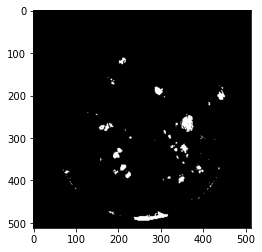

In [43]:
plt.imshow(mask_img, cmap="gray")

In [44]:
# test = data[0]

# img_name = test[0]
# num_labels = test[1]
# centroids = test[2]
# prob_map = test[3]

# print("Name: ", img_name)
# print("Count: ", num_labels)
# print("Centroids Shape: ", centroids.shape)

# plt.figure(figsize=(15,15))
# plt.title("Gaussian Heatmap of mask")
# plt.imshow(prob_map, cmap = 'jet')
# print(prob_map.shape, prob_map.dtype)
# print(type(prob_map))

In [45]:
# print(data)

In [46]:
data = np.array(data)
data = pd.DataFrame(data, columns = ['filename', 'count', 'locations', 'map']) 
data

,filename,count,locations,map
0,48_adhikarisaugat.png,177,"[[ 48.96590909,222.875 ],\n [ 54.13333333,...","[[0. ,0. ,0. ,0. ,..."
1,95_pandirinikhilkumar.png,143,"[[ 60.4375 ,200.6875 ],\n [ 58. ,...","[[0. ,0. ,0. ,0. ,..."
2,22_cheniminenihemanthi.png,92,"[[ 77.82278481,205.13924051],\n [119.01834862,...","[[0. ,0. ,0. ,0. ,..."
3,6_peddinenigowtham.png,385,"[[ 55.5 ,269.14705882],\n [ 67.31403118,...","[[0. ,0. ,0. ,0. ,..."
4,84_vodapallikalyani.png,68,"[[ 75.11111111,204.02222222],\n [ 77.84210526,...","[[0. ,0. ,0. ,0. ,..."
...,...,...,...,...
115,76_dayanasri.png,587,"[[ 64.17647059,218.73529412],\n [ 68. ,...","[[0. ,0. ,0. ,0. ,..."
116,3_anandankit.png,223,"[[ 47.60377358,252.22641509],\n [ 51.34482759,...","[[0. ,0. ,0. ,0. ,..."
117,34_duddukurileelakrishna.png,81,"[[102.33333333,289.33333333],\n [103.125 ,...","[[0. ,0. ,0. ,0. ,..."
118,28_dasarkadeep.png,206,"[[ 40.55984556,260.9034749 ],\n [ 55.13475177,...","[[0. ,0. ,0. ,0. ,..."


In [47]:
data.to_csv('./locating-objects-without-bboxes/data/512_512/images/train/gt.csv', index = False)

In [48]:
# data.to_csv('./locating-objects-without-bboxes/data/512_512/images/test/gt.csv', index = False)

In [49]:
# data.to_csv('./locating-objects-without-bboxes/data/512_512/images/val/gt.csv', index = False)